In [ ]:
# Run once - installation of pandas-profiling 3.0.0
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [207]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
from pandas_profiling import ProfileReport
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Double check - should be 3.0.0
pandas_profiling.version.__version__

'3.0.0'

In [8]:
# Column names
colnames = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "MaritalStatus",
            "Occupation", "Relationship", "Race", "Sex", "CapitalGain", "CapitalLoss", 
            "HoursPerWeek", "NativeCountry", "Target"]

In [10]:
# Loading in the data 
raw_data = pd.read_csv("Data/adult.data", header = None, names = colnames )

In [11]:
# We will be working with df, while keeping raw_data here as a copy
df = raw_data.copy()

In [12]:
# Check the data
df

Age          Workclass  Fnlwgt    Education  Education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

             MaritalStatus          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
32556   Married-civ-spouse        Tech-support            Wife   White   
32557   Married-civ-spouse   Machine-op-inspct         Husband   White   
32558              Widowed        Adm-clerical       Unmarried   White   
32559        Never-married        Adm-clerical       Own-child   White   
32560   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Target  
0         Male         2174            0            40   United-States   <=50K  
1         Male            0            0            13   United-States   <=50K  
2         Male            0            0            40   United-States   <=50K  
3         Male            0            0            40   United-States   <=50K  
4       Female            0            0            40            Cuba   <=50K  
...        ...          ...          ...           ...             ...     ...  
32556   Female            0            0            38   United-States   <=50K  
32557     Male            0            0            40   United-States    >50K  
32558   Female            0            0            40   United-States   <=50K  
32559     Male            0            0            20   United-States   <=50K  
32560   Female        15024            0            40   United-States    >50K  

[32561 rows x 15 columns]

In [13]:
# Change Target column to 1s and 0s
# 1s if >50k, 0s otherwise
df.Target = df.Target.replace(" <=50K", 0).replace(" >50K", 1)

In [14]:
# No missing values?
df.isnull().sum()
# Or all of them rewritten as "?" ?

Age              0
Workclass        0
Fnlwgt           0
Education        0
Education-num    0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Sex              0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
Target           0
dtype: int64

In [15]:
# Most common age numbers
df.Age.value_counts().head(10)

36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
Name: Age, dtype: int64

In [16]:
# Least common age numbers
df.Age.value_counts().tail(10)

80    22
79    22
81    20
82    12
84    10
83     6
85     3
88     3
86     1
87     1
Name: Age, dtype: int64

In [17]:
# 7% (2399 entries) have ?, most of them in multiple columns
# 1836 ? values in Workclass, 1843 in Occupation(mostly same rows as WorkClass) and 583 in NativeCountry
(df == " ?").sum()

Age                 0
Workclass        1836
Fnlwgt              0
Education           0
Education-num       0
MaritalStatus       0
Occupation       1843
Relationship        0
Race                0
Sex                 0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry     583
Target              0
dtype: int64

In [18]:
# Query for all 2399 rows with " ?"
df[(df['Workclass'] == " ?") | (df['Occupation'] == " ?") | (df['NativeCountry'] == " ?")]

Age Workclass  Fnlwgt      Education  Education-num  \
14      40   Private  121772      Assoc-voc             11   
27      54         ?  180211   Some-college             10   
38      31   Private   84154   Some-college             10   
51      18   Private  226956        HS-grad              9   
61      32         ?  293936        7th-8th              4   
...    ...       ...     ...            ...            ...   
32530   35         ?  320084      Bachelors             13   
32531   30         ?   33811      Bachelors             13   
32539   71         ?  287372      Doctorate             16   
32541   41         ?  202822        HS-grad              9   
32542   72         ?  129912        HS-grad              9   

                MaritalStatus      Occupation    Relationship  \
14         Married-civ-spouse    Craft-repair         Husband   
27         Married-civ-spouse               ?         Husband   
38         Married-civ-spouse           Sales         Husband   
51              Never-married   Other-service       Own-child   
61      Married-spouse-absent               ?   Not-in-family   
...                       ...             ...             ...   
32530      Married-civ-spouse               ?            Wife   
32531           Never-married               ?   Not-in-family   
32539      Married-civ-spouse               ?         Husband   
32541               Separated               ?   Not-in-family   
32542      Married-civ-spouse               ?         Husband   

                      Race      Sex  CapitalGain  CapitalLoss  HoursPerWeek  \
14      Asian-Pac-Islander     Male            0            0            40   
27      Asian-Pac-Islander     Male            0            0            60   
38                   White     Male            0            0            38   
51                   White   Female            0            0            30   
61                   White     Male            0            0            40   
...                    ...      ...          ...          ...           ...   
32530                White   Female            0            0            55   
32531   Asian-Pac-Islander   Female            0            0            99   
32539                White     Male            0            0            10   
32541                Black   Female            0            0            32   
32542                White     Male            0            0            25   

        NativeCountry  Target  
14                  ?       1  
27              South       1  
38                  ?       1  
51                  ?       0  
61                  ?       0  
...               ...     ...  
32530   United-States       1  
32531   United-States       0  
32539   United-States       1  
32541   United-States       0  
32542   United-States       0  

[2399 rows x 15 columns]

In [19]:
# Drop those rows
index_to_drop =  df[(df['Workclass'] == " ?") | (df['Occupation'] == " ?") | (df['NativeCountry'] == " ?")].index
df.drop(index_to_drop, axis = 0, inplace= True)

In [20]:
df

Age          Workclass  Fnlwgt    Education  Education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

             MaritalStatus          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
32556   Married-civ-spouse        Tech-support            Wife   White   
32557   Married-civ-spouse   Machine-op-inspct         Husband   White   
32558              Widowed        Adm-clerical       Unmarried   White   
32559        Never-married        Adm-clerical       Own-child   White   
32560   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Target  
0         Male         2174            0            40   United-States       0  
1         Male            0            0            13   United-States       0  
2         Male            0            0            40   United-States       0  
3         Male            0            0            40   United-States       0  
4       Female            0            0            40            Cuba       0  
...        ...          ...          ...           ...             ...     ...  
32556   Female            0            0            38   United-States       0  
32557     Male            0            0            40   United-States       1  
32558   Female            0            0            40   United-States       0  
32559     Male            0            0            20   United-States       0  
32560   Female        15024            0            40   United-States       1  

[30162 rows x 15 columns]

In [21]:
# Check for duplicate rows
df[df.duplicated(keep=False)].sort_values(["Age", "Fnlwgt"])

Age          Workclass  Fnlwgt      Education  Education-num  \
17673   19            Private   97261        HS-grad              9   
18698   19            Private   97261        HS-grad              9   
6990    19            Private  138153   Some-college             10   
21318   19            Private  138153   Some-college             10   
15189   19            Private  146679   Some-college             10   
21490   19            Private  146679   Some-college             10   
3917    19            Private  251579   Some-college             10   
31993   19            Private  251579   Some-college             10   
5805    20            Private  107658   Some-college             10   
11631   20            Private  107658   Some-college             10   
8080    21            Private  243368      Preschool              1   
15059   21            Private  243368      Preschool              1   
4767    21            Private  250051   Some-college             10   
9171    21            Private  250051   Some-college             10   
21103   23            Private  240137        5th-6th              3   
25872   23            Private  240137        5th-6th              3   
5842    25            Private  195994        1st-4th              2   
13084   25            Private  195994        1st-4th              2   
22300   25            Private  195994        1st-4th              2   
4325    25            Private  308144      Bachelors             13   
4881    25            Private  308144      Bachelors             13   
5579    27            Private  255582        HS-grad              9   
28230   27            Private  255582        HS-grad              9   
8679    28            Private  274679        Masters             14   
26313   28            Private  274679        Masters             14   
16846   35            Private  379959        HS-grad              9   
32404   35            Private  379959        HS-grad              9   
4940    38            Private  207202        HS-grad              9   
29157   38            Private  207202        HS-grad              9   
25624   39            Private   30916        HS-grad              9   
28846   39            Private   30916        HS-grad              9   
10367   42            Private  204235   Some-college             10   
28522   42            Private  204235   Some-college             10   
17916   44            Private  367749      Bachelors             13   
22367   44            Private  367749      Bachelors             13   
11965   46            Private  133616   Some-college             10   
30845   46            Private  133616   Some-college             10   
16297   46            Private  173243        HS-grad              9   
17040   46            Private  173243        HS-grad              9   
7920    49            Private   31267        7th-8th              4   
21875   49            Private   31267        7th-8th              4   
7053    49   Self-emp-not-inc   43479   Some-college             10   
22494   49   Self-emp-not-inc   43479   Some-college             10   
2303    90            Private   52386   Some-college             10   
5104    90            Private   52386   Some-college             10   

             MaritalStatus          Occupation    Relationship  \
17673        Never-married     Farming-fishing   Not-in-family   
18698        Never-married     Farming-fishing   Not-in-family   
6990         Never-married        Adm-clerical       Own-child   
21318        Never-married        Adm-clerical       Own-child   
15189        Never-married     Exec-managerial       Own-child   
21490        Never-married     Exec-managerial       Own-child   
3917         Never-married       Other-service       Own-child   
31993        Never-married       Other-service       Own-child   
5805         Never-married        Tech-support   Not-in-family   
11631        Never-married        Tech-support   Not-in-family   
8080         N

In [22]:
# 23 duplicate rows to be removed
df[df.duplicated()].shape[0]

23

In [24]:
# Drop the duplicates and reset the index
df.drop_duplicates(keep = 'first', inplace = True)
df.reset_index(drop=True, inplace= True)

In [25]:
# We are left with 30139 x 15 dataframe
df

Age          Workclass  Fnlwgt    Education  Education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
30134   27            Private  257302   Assoc-acdm             12   
30135   40            Private  154374      HS-grad              9   
30136   58            Private  151910      HS-grad              9   
30137   22            Private  201490      HS-grad              9   
30138   52       Self-emp-inc  287927      HS-grad              9   

             MaritalStatus          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
30134   Married-civ-spouse        Tech-support            Wife   White   
30135   Married-civ-spouse   Machine-op-inspct         Husband   White   
30136              Widowed        Adm-clerical       Unmarried   White   
30137        Never-married        Adm-clerical       Own-child   White   
30138   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Target  
0         Male         2174            0            40   United-States       0  
1         Male            0            0            13   United-States       0  
2         Male            0            0            40   United-States       0  
3         Male            0            0            40   United-States       0  
4       Female            0            0            40            Cuba       0  
...        ...          ...          ...           ...             ...     ...  
30134   Female            0            0            38   United-States       0  
30135     Male            0            0            40   United-States       1  
30136   Female            0            0            40   United-States       0  
30137     Male            0            0            20   United-States       0  
30138   Female        15024            0            40   United-States       1  

[30139 rows x 15 columns]

In [27]:
# Create pandas profiling report
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Dropping Fnlwgt column
df.drop("Fnlwgt", axis = 1, inplace = True)

In [29]:
df

Age          Workclass    Education  Education-num  \
0       39          State-gov    Bachelors             13   
1       50   Self-emp-not-inc    Bachelors             13   
2       38            Private      HS-grad              9   
3       53            Private         11th              7   
4       28            Private    Bachelors             13   
...    ...                ...          ...            ...   
30134   27            Private   Assoc-acdm             12   
30135   40            Private      HS-grad              9   
30136   58            Private      HS-grad              9   
30137   22            Private      HS-grad              9   
30138   52       Self-emp-inc      HS-grad              9   

             MaritalStatus          Occupation    Relationship    Race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
30134   Married-civ-spouse        Tech-support            Wife   White   
30135   Married-civ-spouse   Machine-op-inspct         Husband   White   
30136              Widowed        Adm-clerical       Unmarried   White   
30137        Never-married        Adm-clerical       Own-child   White   
30138   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Target  
0         Male         2174            0            40   United-States       0  
1         Male            0            0            13   United-States       0  
2         Male            0            0            40   United-States       0  
3         Male            0            0            40   United-States       0  
4       Female            0            0            40            Cuba       0  
...        ...          ...          ...           ...             ...     ...  
30134   Female            0            0            38   United-States       0  
30135     Male            0            0            40   United-States       1  
30136   Female            0            0            40   United-States       0  
30137     Male            0            0            20   United-States       0  
30138   Female        15024            0            40   United-States       1  

[30139 rows x 14 columns]

In [93]:
# Get the list of all categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# Remove all leading white spaces
for column in cat_columns:
    df[f"{column}"] = df[f"{column}"].str.strip()

# Turn them into categorical features
df[cat_columns] = df[cat_columns].astype('category')

In [99]:
df.dtypes

Age                 int64
Workclass        category
Education        category
Education-num       int64
MaritalStatus    category
Occupation       category
Relationship     category
Race             category
Sex              category
CapitalGain         int64
CapitalLoss         int64
HoursPerWeek        int64
NativeCountry    category
Target              int64
dtype: object

ML

In [240]:
X = df.drop('Target', axis=1)
y = df['Target']

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 2019)

In [242]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [243]:
cm = confusion_matrix(y_test, sta)
print('Confusion matrix\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix
 [[4239  288]
 [ 483 1018]]

True Positives(TP) =  4239

True Negatives(TN) =  1018

False Positives(FP) =  288

False Negatives(FN) =  483


0.8720968812209688


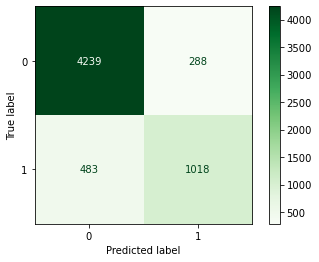

In [244]:
score1=accuracy_score(y_test,y_pred)
print(score1)
plot_confusion_matrix(clf, X_test, y_test, cmap='Greens')
plt.show()

In [245]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4527
           1       0.78      0.68      0.73      1501

    accuracy                           0.87      6028
   macro avg       0.84      0.81      0.82      6028
weighted avg       0.87      0.87      0.87      6028



In [166]:
varimp = pd.DataFrame({'Feature' : X.columns, 'Importance': clf.feature_importances_})
varimp.sort_values(by = 'Importance', ascending= False)

Feature  Importance
0             Age         787
11   HoursPerWeek         449
9     CapitalGain         410
3   Education-num         349
10    CapitalLoss         329
5      Occupation         203
1       Workclass         105
8             Sex          87
12  NativeCountry          73
6    Relationship          71
2       Education          59
4   MaritalStatus          56
7            Race          22

In [187]:
X_train

Age         Workclass  Education  Education-num       MaritalStatus  \
13437   51  Self-emp-not-inc  Bachelors             13  Married-civ-spouse   
30137   22           Private    HS-grad              9       Never-married   
24165   41         Local-gov    HS-grad              9  Married-civ-spouse   
4120    50         State-gov  Bachelors             13  Married-civ-spouse   
12779   38           Private  Assoc-voc             11  Married-civ-spouse   
...    ...               ...        ...            ...                 ...   
16759   50         Local-gov  Bachelors             13  Married-civ-spouse   
18474   50           Private    HS-grad              9            Divorced   
19511   42           Private    7th-8th              4       Never-married   
16086   42         Local-gov    Masters             14           Separated   
2413    32           Private  Bachelors             13  Married-civ-spouse   

              Occupation   Relationship   Race     Sex  CapitalGain  \
13437    Exec-managerial           Wife  White  Female            0   
30137       Adm-clerical      Own-child  White    Male            0   
24165    Protective-serv        Husband  White    Male            0   
4120     Exec-managerial        Husband  White    Male            0   
12779    Exec-managerial        Husband  White    Male            0   
...                  ...            ...    ...     ...          ...   
16759    Protective-serv        Husband  White    Male            0   
18474      Other-service  Not-in-family  White    Male            0   
19511  Handlers-cleaners  Not-in-family  Black    Male            0   
16086    Exec-managerial      Unmarried  Black    Male            0   
2413        Tech-support        Husband  White    Male        15024   

       CapitalLoss  HoursPerWeek  NativeCountry  
13437            0            40  United-States  
30137            0            20  United-States  
24165            0            40  United-States  
4120             0            40  United-States  
12779            0            50  United-States  
...            ...           ...            ...  
16759            0            44  United-States  
18474            0            40  United-States  
19511         2205            40  United-States  
16086            0            45  United-States  
2413             0            40  United-States  

[24111 rows x 13 columns]

In [196]:
val_acc_max_depth=[]
val_f1_max_depth=[]
train_acc_max_depth=[]
train_f1_max_depth=[]
val_range=(1,10,1)

for i in range(val_range[0],val_range[1],val_range[2]):
    clf = lgb.LGBMClassifier(max_depth = i)
    clf.fit(X_train, y_train)
    pred_val = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_test,pred_val)
    f1_val = f1_score(y_test,pred_val,average='micro')
    train_acc_max_depth.append(acc_train)
    train_f1_max_depth.append(f1_train)
    val_acc_max_depth.append(acc_val)
    val_f1_max_depth.append(f1_val)

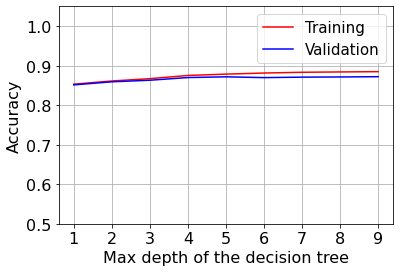

In [197]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_max_depth,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_max_depth,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Max depth of the decision tree", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1.05)
plt.show()

In [ ]:
val_acc_max_depth=[]
val_f1_max_depth=[]
train_acc_max_depth=[]
train_f1_max_depth=[]
val_range=(1,41,1)

for i in range(val_range[0],val_range[1],val_range[2]):
    clf = lgb.LGBMClassifier(max_depth = 4, min_data_in_leaf = i)
    clf.fit(X_train, y_train)
    pred_val = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_test,pred_val)
    f1_val = f1_score(y_test,pred_val,average='micro')
    train_acc_max_depth.append(acc_train)
    train_f1_max_depth.append(f1_train)
    val_acc_max_depth.append(acc_val)
    val_f1_max_depth.append(f1_val)

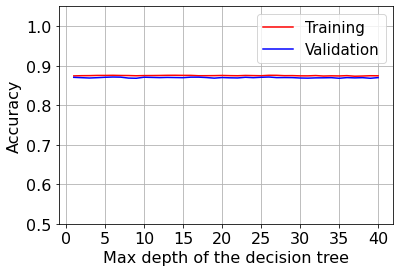

In [200]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_max_depth,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_max_depth,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Max depth of the decision tree", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1.05)
plt.show()

RF

In [201]:
df_dummy = pd.get_dummies(df)
df_dummy

Age  Education-num  CapitalGain  CapitalLoss  HoursPerWeek  Target  \
0       39             13         2174            0            40       0   
1       50             13            0            0            13       0   
2       38              9            0            0            40       0   
3       53              7            0            0            40       0   
4       28             13            0            0            40       0   
...    ...            ...          ...          ...           ...     ...   
30134   27             12            0            0            38       0   
30135   40              9            0            0            40       1   
30136   58              9            0            0            40       0   
30137   22              9            0            0            20       0   
30138   52              9        15024            0            40       1   

       Workclass_Federal-gov  Workclass_Local-gov  Workclass_Private  \
0                          0                    0                  0   
1                          0                    0                  0   
2                          0                    0                  1   
3                          0                    0                  1   
4                          0                    0                  1   
...                      ...                  ...                ...   
30134                      0                    0                  1   
30135                      0                    0                  1   
30136                      0                    0                  1   
30137                      0                    0                  1   
30138                      0                    0                  0   

       Workclass_Self-emp-inc  ...  NativeCountry_Portugal  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   
...                       ...  ...                     ...   
30134                       0  ...                       0   
30135                       0  ...                       0   
30136                       0  ...                       0   
30137                       0  ...                       0   
30138                       1  ...                       0   

       NativeCountry_Puerto-Rico  NativeCountry_Scotland  NativeCountry_South  \
0                              0                       0                    0   
1                              0                       0                    0   
2                              0                       0                    0   
3                              0                       0                    0   
4                              0                       0                    0   
...                          ...                     ...                  ...   
30134                          0                       0                    0   
30135                          0                       0                    0   
30136                          0                       0                    0   
30137                          0                       0                    0   
30138                          0                       0                    0   

       NativeCountry_Taiwan  NativeCountry_Thailand  \
0                         0                       0   
1                         0                       0   
2                         0                       0   
3                         0                       0   
4                         0                       0   
...                     ...                     ...   
30134                     0                       0   
30135                     0                       0   
3013

In [204]:
X = df_dummy.drop('Target', axis = 1)
y = df_dummy['Target']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 2019)

0.8498672859986729


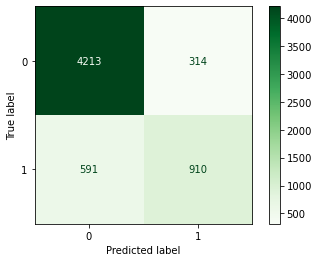

In [211]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=6)
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
score1=accuracy_score(y_test,predictions)
print(score1)
plot_confusion_matrix(dtree, X_test, y_test, cmap='Greens')
plt.show()

In [216]:
val_acc_max_depth=[]
val_f1_max_depth=[]
train_acc_max_depth=[]
train_f1_max_depth=[]
val_range=(1,31,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=i,min_samples_leaf=1)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_test)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_test,pred_val)
    f1_val = f1_score(y_test,pred_val,average='micro')
    train_acc_max_depth.append(acc_train)
    train_f1_max_depth.append(f1_train)
    val_acc_max_depth.append(acc_val)
    val_f1_max_depth.append(f1_val)

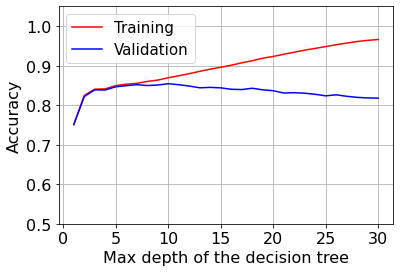

In [217]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_max_depth,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_max_depth,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Max depth of the decision tree", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1.05)
plt.show()

In [218]:
X_val = X_test
y_val = y_test

In [223]:
val_acc_min_samples_leaf=[]
val_f1_min_samples_leaf=[]
train_acc_min_samples_leaf=[]
train_f1_min_samples_leaf=[]
val_range=(1,41,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=i)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_val)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    train_acc_min_samples_leaf.append(acc_train)
    train_f1_min_samples_leaf.append(f1_train)
    val_acc_min_samples_leaf.append(acc_val)
    val_f1_min_samples_leaf.append(f1_val)

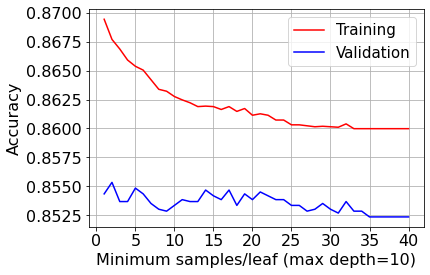

In [224]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_min_samples_leaf,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_min_samples_leaf,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Minimum samples/leaf (max depth=10)", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
#plt.ylim(0.7,1.0)
plt.show()

In [227]:
val_acc_train_size=[]
val_f1_train_size=[]
train_acc_train_size=[]
train_f1_train_size=[]
val_range=(10,101,5)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    percentage=i*0.01
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=5)
    # Sampling
    df_sampled = df_dummy.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('Target',axis=1)
    y_train_sampled=df_sampled['Target']
    # Fitting and Predictions
    dtree.fit(X_train_sampled,y_train_sampled)
    pred_train = dtree.predict(X_train_sampled)
    pred_val = dtree.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train_sampled,pred_train)
    f1_train = f1_score(y_train_sampled,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_train_size.append(acc_train)
    train_f1_train_size.append(f1_train)
    val_acc_train_size.append(acc_val)
    val_f1_train_size.append(f1_val)
    if i%10==0:
        print(f"Done for: {i}% training set size")

Done for: 10% training set size
Done for: 20% training set size
Done for: 30% training set size
Done for: 40% training set size
Done for: 50% training set size
Done for: 60% training set size
Done for: 70% training set size
Done for: 80% training set size
Done for: 90% training set size
Done for: 100% training set size


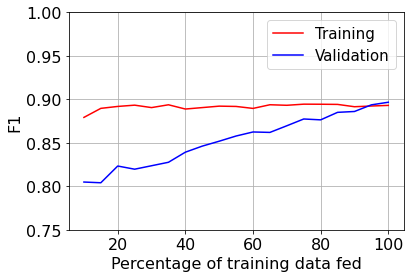

In [252]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_f1_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_f1_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("F1",fontsize=16)
plt.ylim(0.75,1.0)
plt.show()

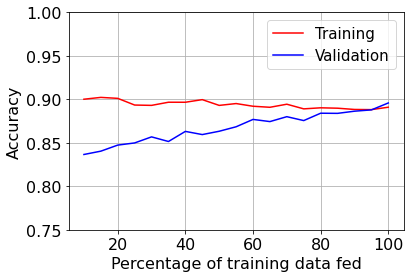

In [228]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.75,1.0)
plt.show()

In [230]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [231]:
X_train_scaled=StandardScaler().fit_transform(X_train)
X_val_scaled=StandardScaler().fit_transform(X_val)

0.8083941605839416


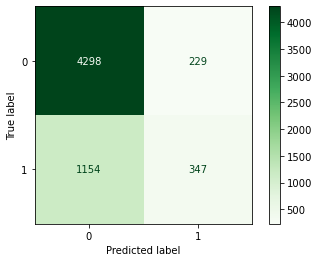

In [237]:
knn=KNeighborsClassifier(3)
knn.fit(X_train_scaled,y_train)
predictions=knn.predict(X_val_scaled)
score1=accuracy_score(y_test,predictions)
print(score1)
plot_confusion_matrix(knn, X_test, y_test, cmap='Greens')
plt.show()

In [238]:
val_acc_k=[]
val_f1_k=[]
train_acc_k=[]
train_f1_k=[]
val_range=(1,21,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    knn=KNeighborsClassifier(i)
    knn.fit(X_train_scaled,y_train)
    pred_train = knn.predict(X_train_scaled)
    pred_val = knn.predict(X_val_scaled)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_k.append(acc_train)
    train_f1_k.append(f1_train)
    val_acc_k.append(acc_val)
    val_f1_k.append(f1_val)
    print(f"Done for number of neighbors: {i}")

Done for number of neighbors: 1
Done for number of neighbors: 2
Done for number of neighbors: 3
Done for number of neighbors: 4
Done for number of neighbors: 5
Done for number of neighbors: 6
Done for number of neighbors: 7
Done for number of neighbors: 8
Done for number of neighbors: 9
Done for number of neighbors: 10
Done for number of neighbors: 11
Done for number of neighbors: 12
Done for number of neighbors: 13
Done for number of neighbors: 14
Done for number of neighbors: 15
Done for number of neighbors: 16
Done for number of neighbors: 17
Done for number of neighbors: 18
Done for number of neighbors: 19
Done for number of neighbors: 20


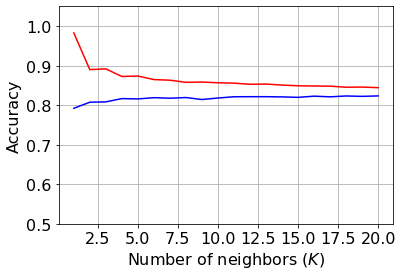

In [239]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_k,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_k,c='blue')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of neighbors ($K$)", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1.05)
plt.show()

In [248]:
val_acc_train_size=[]
val_f1_train_size=[]
train_acc_train_size=[]
train_f1_train_size=[]
val_range=(10,101,5)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    percentage=i*0.01
    knn=KNeighborsClassifier(3)
   # Sampling
    df_sampled = df_dummy.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('Target',axis=1)
    y_train_sampled=df_sampled['Target']
    X_train_sampled=StandardScaler().fit_transform(X_train_sampled)
    # Fitting and prediction
    knn.fit(X_train_sampled,y_train_sampled)
    pred_train = knn.predict(X_train_sampled)
    pred_val = knn.predict(X_val_scaled)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train_sampled,pred_train)
    f1_train = f1_score(y_train_sampled,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_train_size.append(acc_train)
    train_f1_train_size.append(f1_train)
    val_acc_train_size.append(acc_val)
    val_f1_train_size.append(f1_val)
    
    if i%10==0:
        print(f"Done for: {i}% training set size")

Done for: 10% training set size
Done for: 20% training set size
Done for: 30% training set size
Done for: 40% training set size
Done for: 50% training set size
Done for: 60% training set size
Done for: 70% training set size
Done for: 80% training set size
Done for: 90% training set size
Done for: 100% training set size


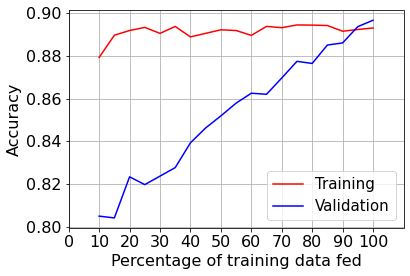

In [249]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(np.arange(0, 110, step=10),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
#plt.ylim(0.7,0.9)
plt.xlim(0,110)
plt.show()

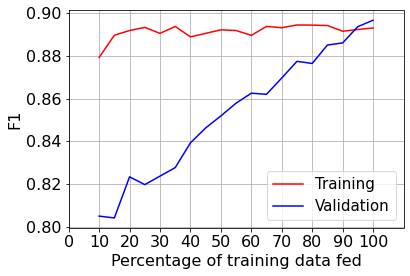

In [251]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_f1_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_f1_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(np.arange(0, 110, step=10),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("F1",fontsize=16)
#plt.ylim(0.7,0.9)
plt.xlim(0,110)
plt.show()

In [259]:
pd.read_csv("../../Downloads/adult.test")

|1x3 Cross validator
25  Private      226802  11th         7   Never-married       Machine-op-inspct  Own-child       Black               Male   0    0 40  United-States               <=50K.
38  Private      89814   HS-grad      9   Married-civ-spouse  Farming-fishing    Husband         White               Male   0    0 50  United-States               <=50K.
28  Local-gov    336951  Assoc-acdm   12  Married-civ-spouse  Protective-serv    Husband         White               Male   0    0 40  United-States                >50K.
44  Private      160323  Some-college 10  Married-civ-spouse  Machine-op-inspct  Husband         Black               Male   7688 0 40  United-States                >50K.
18  ?            103497  Some-college 10  Never-married       ?                  Own-child       White               Female 0    0 30  United-States               <=50K.
...                                                                                                                                                                   ...
39  Private      215419  Bachelors    13  Divorced            Prof-specialty     Not-in-family   White               Female 0    0 36  United-States               <=50K.
64  ?            321403  HS-grad      9   Widowed             ?                  Other-relative  Black               Male   0    0 40  United-States               <=50K.
38  Private      374983  Bachelors    13  Married-civ-spouse  Prof-specialty     Husband         White               Male   0    0 50  United-States               <=50K.
44  Private      83891   Bachelors    13  Divorced            Adm-clerical       Own-child       Asian-Pac-Islander  Male   5455 0 40  United-States               <=50K.
35  Self-emp-inc 182148  Bachelors    13  Married-civ-spouse  Exec-managerial    Husband         White               Male   0    0 60  United-States                >50K.

[16281 rows x 1 columns]